In [1]:
import pandas as pd

# Path to HYPERAKTIV dataset
BASE = "/Users/callyminner/StThomas/SEIS631/ChooseYourOwnHypothesis/Repo/Data/hyperaktiv/"  

def read_semicolon_csv(path):
    """
    Reads semicolon-separated CSVs where delimiters may include extra spaces.
    Uses regex to handle both ';' and ';   ' and prevents parsing errors.
    """
    return pd.read_csv(path, sep=r';\s*', engine='python')

# -------------------------
# LOAD patient_info.csv
# -------------------------
patient_info = read_semicolon_csv(BASE + "patient_info.csv")

print("Columns in patient_info:")
print(patient_info.columns.tolist())

print("\nFirst 5 rows of patient_info:")
print(patient_info.head())

Columns in patient_info:
['ID', 'SEX', 'AGE', 'ACC', 'ACC_TIME', 'ACC_DAYS', 'HRV', 'HRV_TIME', 'HRV_HOURS', 'CPT_II', 'ADHD', 'ADD', 'BIPOLAR', 'UNIPOLAR', 'ANXIETY', 'SUBSTANCE', 'OTHER', 'CT', 'MDQ_POS', 'WURS', 'ASRS', 'MADRS', 'HADS_A', 'HADS_D', 'MED', 'MED_Antidepr', 'MED_Moodstab', 'MED_Antipsych', 'MED_Anxiety_Benzo', 'MED_Sleep', 'MED_Analgesics_Opioids', 'MED_Stimulants', 'filter_$']

First 5 rows of patient_info:
   ID  SEX  AGE  ACC  ACC_TIME  ACC_DAYS  HRV  HRV_TIME  HRV_HOURS  CPT_II  \
0   1    0    3    1  16:00:00       6.0    1  11:00:00       21.0       0   
1   2    0    4    1  10:54:00       6.8    0       NaN        NaN       1   
2   3    1    2    1  15:28:00       7.2    1  15:25:00       21.0       1   
3   4    1    3    0       NaN       NaN    1  16:55:00       22.0       1   
4   5    1    1    1  14:24:00       5.9    1  16:00:00       12.0       1   

   ...  HADS_D  MED  MED_Antidepr  MED_Moodstab  MED_Antipsych  \
0  ...     2.0    1           1.0   

In [2]:
# ----------------------------------------------------
# STEP 2 — CLEAN AND STANDARDIZE patient_info
# ----------------------------------------------------

# 1. Rename important columns for clarity
patient_info = patient_info.rename(columns={
    "ID": "patient_id",
    "SEX": "sex",
    "AGE": "age_group"
})

# 2. Convert sex from 0/1 to categorical labels
sex_map = {0: "Female", 1: "Male"}
patient_info["sex"] = patient_info["sex"].map(sex_map)

# 3. Convert age_group codes to real age ranges
age_map = {
    1: "17-29",
    2: "30-39",
    3: "40-49",
    4: "50-67"
}
patient_info["age_group_label"] = patient_info["age_group"].map(age_map)

# 4. Convert diagnosis fields (0/1) to boolean integers
diagnosis_cols = [
    "ADHD", "ADD", "BIPOLAR", "UNIPOLAR",
    "ANXIETY", "SUBSTANCE", "OTHER"
]

for col in diagnosis_cols:
    patient_info[col] = patient_info[col].astype(int)

# 5. Ensure clinical scales are numeric
clinical_cols = [
    "WURS", "ASRS", "MADRS", "HADS_A", "HADS_D"
]

for col in clinical_cols:
    patient_info[col] = pd.to_numeric(patient_info[col], errors="coerce")

# 6. Convert medication flags to booleans
med_cols = [
    "MED", "MED_Antidepr", "MED_Moodstab", "MED_Antipsych",
    "MED_Anxiety_Benzo", "MED_Sleep",
    "MED_Analgesics_Opioids", "MED_Stimulants"
]

for col in med_cols:
    patient_info[col] = patient_info[col].fillna(0).astype(int)

# 7. OPTIONAL: Remove the odd filter column unless needed
if "filter_$" in patient_info.columns:
    patient_info = patient_info.drop(columns=["filter_$"])

# 8. Show results
print("Cleaned patient_info columns:\n", patient_info.columns.tolist())
print("\nPreview of cleaned patient_info:\n", patient_info.head())


Cleaned patient_info columns:
 ['patient_id', 'sex', 'age_group', 'ACC', 'ACC_TIME', 'ACC_DAYS', 'HRV', 'HRV_TIME', 'HRV_HOURS', 'CPT_II', 'ADHD', 'ADD', 'BIPOLAR', 'UNIPOLAR', 'ANXIETY', 'SUBSTANCE', 'OTHER', 'CT', 'MDQ_POS', 'WURS', 'ASRS', 'MADRS', 'HADS_A', 'HADS_D', 'MED', 'MED_Antidepr', 'MED_Moodstab', 'MED_Antipsych', 'MED_Anxiety_Benzo', 'MED_Sleep', 'MED_Analgesics_Opioids', 'MED_Stimulants', 'age_group_label']

Preview of cleaned patient_info:
    patient_id     sex  age_group  ACC  ACC_TIME  ACC_DAYS  HRV  HRV_TIME  \
0           1  Female          3    1  16:00:00       6.0    1  11:00:00   
1           2  Female          4    1  10:54:00       6.8    0       NaN   
2           3    Male          2    1  15:28:00       7.2    1  15:25:00   
3           4    Male          3    0       NaN       NaN    1  16:55:00   
4           5    Male          1    1  14:24:00       5.9    1  16:00:00   

   HRV_HOURS  CPT_II  ...  HADS_D  MED  MED_Antidepr  MED_Moodstab  \
0       21.0 

In [3]:
# ----------------------------------------------------
# STEP 3 — BUILD MASTER TABLE
# ----------------------------------------------------

# Load the remaining top-level files
features = read_semicolon_csv(BASE + "features.csv")
cpt = read_semicolon_csv(BASE + "CPT_II_ConnersContinuousPerformanceTest.csv")

# Rename ID column if present
if "ID" in features.columns:
    features = features.rename(columns={"ID": "patient_id"})
if "ID" in cpt.columns:
    cpt = cpt.rename(columns={"ID": "patient_id"})

# Ensure patient_id is string for safe merging
patient_info["patient_id"] = patient_info["patient_id"].astype(str)
features["patient_id"] = features["patient_id"].astype(str)
cpt["patient_id"] = cpt["patient_id"].astype(str)

# Perform incremental merges
master = patient_info.merge(features, on="patient_id", how="left")
master = master.merge(cpt, on="patient_id", how="left")

print("Master table shape:", master.shape)
print("\nMaster table sample:\n", master.head())
print("\nMaster table columns:\n", master.columns.tolist())

Master table shape: (103, 1605)

Master table sample:
   patient_id     sex  age_group  ACC  ACC_TIME  ACC_DAYS  HRV  HRV_TIME  \
0          1  Female          3    1  16:00:00       6.0    1  11:00:00   
1          2  Female          4    1  10:54:00       6.8    0       NaN   
2          3    Male          2    1  15:28:00       7.2    1  15:25:00   
3          4    Male          3    0       NaN       NaN    1  16:55:00   
4          5    Male          1    1  14:24:00       5.9    1  16:00:00   

   HRV_HOURS  CPT_II  ...  Raw Score HitRTIsi  Percent HitRTIsi  \
0       21.0       0  ...                 NaN               NaN   
1        NaN       1  ...            0.049592               0.0   
2       21.0       1  ...            0.064090               0.0   
3       22.0       1  ...            0.077233               0.0   
4       12.0       1  ...            0.085540               0.0   

   General TScore HitSEIsi  Adhd TScore HitSEIsi  Neuro TScore HitSEIsi  \
0               

In [4]:
master['BIPOLAR']

0      1
1      0
2      1
3      1
4      1
      ..
98     0
99     1
100    0
101    1
102    0
Name: BIPOLAR, Length: 103, dtype: int64

In [5]:
master[['ADHD', 'BIPOLAR']]   #do a permutation test by scrambling one of these columns

,ADHD,BIPOLAR
0,1,1
1,1,0
2,1,1
3,1,1
4,1,1
...,...,...
98,0,0
99,0,1
100,0,0
101,0,1


In [6]:
pd.crosstab(master['ADHD'], master['BIPOLAR'])  #then make this from the scrambled results? chi-square test of significance

BIPOLAR,0,1
ADHD,,
0,28,24
1,33,18


In [7]:
master[['ADHD', 'UNIPOLAR']]

,ADHD,UNIPOLAR
0,1,0
1,1,1
2,1,0
3,1,0
4,1,0
...,...,...
98,0,1
99,0,0
100,0,1
101,0,0


In [8]:
pd.crosstab(master['ADHD'], master['UNIPOLAR'])

UNIPOLAR,0,1
ADHD,,
0,38,14
1,34,17


In [9]:
master[['ADHD', 'ANXIETY']]

,ADHD,ANXIETY
0,1,1
1,1,0
2,1,0
3,1,1
4,1,1
...,...,...
98,0,1
99,0,1
100,0,1
101,0,1


In [10]:
pd.crosstab(master['ADHD'], master['ANXIETY'])

ANXIETY,0,1,9
ADHD,,,
0,16,35,1
1,29,22,0


In [11]:
master[['ADHD', 'SUBSTANCE']]

,ADHD,SUBSTANCE
0,1,0
1,1,0
2,1,1
3,1,1
4,1,0
...,...,...
98,0,0
99,0,0
100,0,1
101,0,0


In [12]:
pd.crosstab(master['ADHD'], master['SUBSTANCE'])

SUBSTANCE,0,1,9
ADHD,,,
0,43,8,1
1,35,16,0


In [13]:
master[['ADHD', 'ADD']]

,ADHD,ADD
0,1,0
1,1,0
2,1,0
3,1,0
4,1,1
...,...,...
98,0,0
99,0,0
100,0,0
101,0,0


In [14]:
pd.crosstab(master['ADHD'], master['ADD'])

ADD,0,1
ADHD,,
0,52,0
1,28,23


In [15]:
# ----------------------------------------------------
# STEP 4 — ADHD PREVALENCE ANALYSIS
# ----------------------------------------------------

# 1. Prevalence by sex
adhd_by_sex = master.groupby("sex")["ADHD"].mean().reset_index()
adhd_by_sex["ADHD_prevalence_pct"] = adhd_by_sex["ADHD"] * 100

print("ADHD prevalence by sex (%):")
print(adhd_by_sex, "\n")


# 2. Prevalence by age group
adhd_by_age = master.groupby("age_group_label")["ADHD"].mean().reset_index()
adhd_by_age["ADHD_prevalence_pct"] = adhd_by_age["ADHD"] * 100

print("ADHD prevalence by age group (%):")
print(adhd_by_age, "\n")


# 3. Prevalence by sex × age group (interaction)
adhd_by_sex_age = (
    master.groupby(["sex", "age_group_label"])["ADHD"]
    .mean()
    .reset_index()
)
adhd_by_sex_age["ADHD_prevalence_pct"] = adhd_by_sex_age["ADHD"] * 100

print("ADHD prevalence by sex × age group (%):")
print(adhd_by_sex_age, "\n")


# 4. Count table (optional but useful)
counts = master.groupby(["sex", "age_group_label"])["ADHD"].agg(["sum", "count"])
counts["prevalence_pct"] = (counts["sum"] / counts["count"]) * 100

print("Counts + prevalence table:")
print(counts)


ADHD prevalence by sex (%):
      sex      ADHD  ADHD_prevalence_pct
0  Female  0.460000            46.000000
1    Male  0.528302            52.830189 

ADHD prevalence by age group (%):
  age_group_label      ADHD  ADHD_prevalence_pct
0           17-29  0.428571            42.857143
1           30-39  0.517241            51.724138
2           40-49  0.533333            53.333333
3           50-67  0.500000            50.000000 

ADHD prevalence by sex × age group (%):
      sex age_group_label      ADHD  ADHD_prevalence_pct
0  Female           17-29  0.421053            42.105263
1  Female           30-39  0.538462            53.846154
2  Female           40-49  0.400000            40.000000
3  Female           50-67  0.500000            50.000000
4    Male           17-29  0.444444            44.444444
5    Male           30-39  0.500000            50.000000
6    Male           40-49  0.600000            60.000000
7    Male           50-67  0.500000            50.000000 

Counts + pr

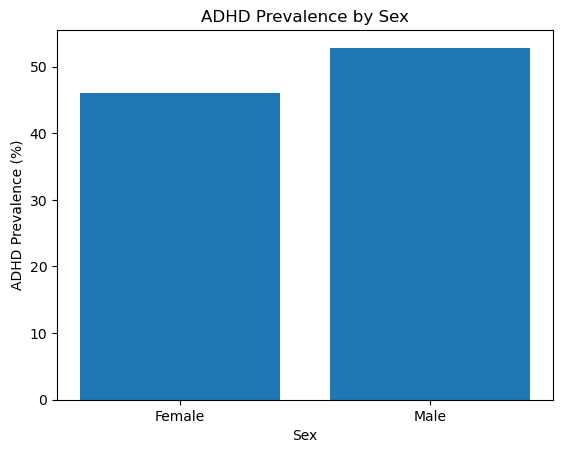

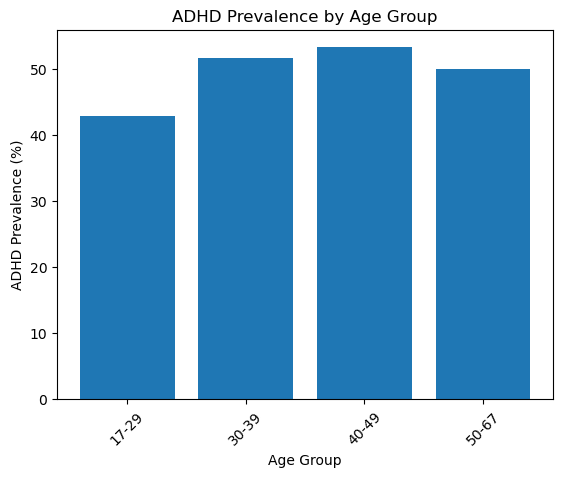

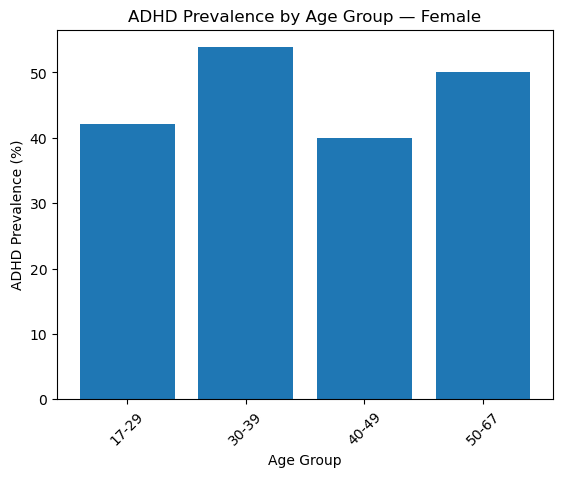

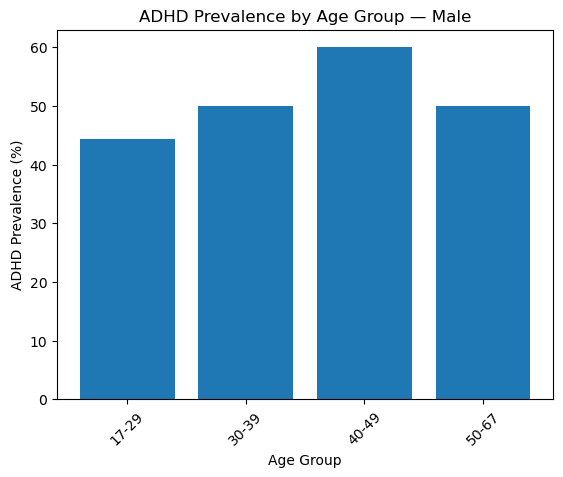

In [16]:
import matplotlib.pyplot as plt

# ----------------------------------------------------
# PLOT 1 — ADHD Prevalence by Sex
# ----------------------------------------------------
adhd_by_sex = master.groupby("sex")["ADHD"].mean() * 100

plt.figure()
plt.bar(adhd_by_sex.index, adhd_by_sex.values)
plt.xlabel("Sex")
plt.ylabel("ADHD Prevalence (%)")
plt.title("ADHD Prevalence by Sex")
plt.show()


# ----------------------------------------------------
# PLOT 2 — ADHD Prevalence by Age Group
# ----------------------------------------------------
adhd_by_age = master.groupby("age_group_label")["ADHD"].mean() * 100

plt.figure()
plt.bar(adhd_by_age.index, adhd_by_age.values)
plt.xlabel("Age Group")
plt.ylabel("ADHD Prevalence (%)")
plt.title("ADHD Prevalence by Age Group")
plt.xticks(rotation=45)
plt.show()


# ----------------------------------------------------
# PLOT 3 — ADHD Prevalence by Sex × Age Group
# ----------------------------------------------------
adhd_by_sex_age = (
    master.groupby(["sex", "age_group_label"])["ADHD"]
    .mean()
    .reset_index()
)
adhd_by_sex_age["ADHD_pct"] = adhd_by_sex_age["ADHD"] * 100

# Plot each sex separately
for sex in adhd_by_sex_age["sex"].unique():
    subset = adhd_by_sex_age[adhd_by_sex_age["sex"] == sex]
    plt.figure()
    plt.bar(subset["age_group_label"], subset["ADHD_pct"])
    plt.xlabel("Age Group")
    plt.ylabel("ADHD Prevalence (%)")
    plt.title(f"ADHD Prevalence by Age Group — {sex}")
    plt.xticks(rotation=45)
    plt.show()

In [17]:
from scipy.stats import chi2_contingency

# ----------------------------------------------------
# 1. SEX × ADHD
# ----------------------------------------------------
sex_table = pd.crosstab(master["sex"], master["ADHD"])
chi2, p, dof, expected = chi2_contingency(sex_table)

print("SEX × ADHD Chi-Square Test")
print("Chi-square:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected counts:\n", expected, "\n")


# ----------------------------------------------------
# 2. AGE GROUP × ADHD
# ----------------------------------------------------
age_table = pd.crosstab(master["age_group_label"], master["ADHD"])
chi2, p, dof, expected = chi2_contingency(age_table)

print("AGE GROUP × ADHD Chi-Square Test")
print("Chi-square:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected counts:\n", expected, "\n")


# ----------------------------------------------------
# 3. SEX × AGE GROUP × ADHD (stratified)
# ----------------------------------------------------
print("SEX × AGE GROUP × ADHD (stratified chi-square tests):\n")
for sex in master["sex"].unique():
    subset = master[master["sex"] == sex]
    table = pd.crosstab(subset["age_group_label"], subset["ADHD"])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"Sex = {sex}")
    print("Chi-square:", chi2)
    print("p-value:", p)
    print("Degrees of freedom:", dof)
    print()


SEX × ADHD Chi-Square Test
Chi-square: 0.24578612794900276
p-value: 0.6200579491814038
Degrees of freedom: 1
Expected counts:
 [[25.24271845 24.75728155]
 [26.75728155 26.24271845]] 

AGE GROUP × ADHD Chi-Square Test
Chi-square: 0.7296046977588557
p-value: 0.8662195115744181
Degrees of freedom: 3
Expected counts:
 [[14.13592233 13.86407767]
 [14.6407767  14.3592233 ]
 [15.14563107 14.85436893]
 [ 8.0776699   7.9223301 ]] 

SEX × AGE GROUP × ADHD (stratified chi-square tests):

Sex = Female
Chi-square: 0.6346691701382773
p-value: 0.8884517858444678
Degrees of freedom: 3

Sex = Male
Chi-square: 0.7436825396825397
p-value: 0.862884390947689
Degrees of freedom: 3



In [18]:
clinical_vars = ["WURS", "ASRS", "HADS_A", "HADS_D", "MADRS"]

# ----------------------------------------------------
# 1. Mean severity by sex
# ----------------------------------------------------
means_by_sex = master.groupby("sex")[clinical_vars].mean()
print("Mean Severity Scores by Sex:")
print(means_by_sex, "\n")


# ----------------------------------------------------
# 2. Mean severity by age group
# ----------------------------------------------------
means_by_age = master.groupby("age_group_label")[clinical_vars].mean()
print("Mean Severity Scores by Age Group:")
print(means_by_age, "\n")


# ----------------------------------------------------
# 3. Mean severity by sex × age group
# ----------------------------------------------------
means_by_sex_age = master.groupby(["sex", "age_group_label"])[clinical_vars].mean()
print("Mean Severity Scores by Sex × Age Group:")
print(means_by_sex_age, "\n")


Mean Severity Scores by Sex:
             WURS       ASRS    HADS_A    HADS_D      MADRS
sex                                                        
Female  43.391304  40.636364  9.390244  4.268293  12.547619
Male    39.134615  39.884615  9.893617  5.936170  14.979167 

Mean Severity Scores by Age Group:
                      WURS       ASRS     HADS_A    HADS_D      MADRS
age_group_label                                                      
17-29            41.884615  39.800000   9.590909  4.136364  11.681818
30-39            41.413793  42.857143  10.357143  4.964286  14.586207
40-49            38.642857  38.785714   8.833333  5.625000  14.880000
50-67            43.933333  38.733333   9.785714  6.357143  13.857143 

Mean Severity Scores by Sex × Age Group:
                             WURS       ASRS     HADS_A    HADS_D      MADRS
sex    age_group_label                                                      
Female 17-29            43.882353  41.125000   9.933333  4.200000  12.600000
